# Initializations

### imports

In [ ]:
from torchvision.datasets import MNIST
from sklearn import datasets
import seaborn as sns

from collections import Counter
import torch
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [90]:
batch_size_train = 128
batch_size_test = 100
mode = "asymmetric" # Can be symmetric, assymetric or original (default)

### Creating definitions for symmetric and asymmetric noises

In [96]:
# Creating symmetric noise for 1,2 and 5 as 9,7 and 8
symmetric_noise = {
    0: 0,
    1: 9,
    9: 1,
    2: 7,
    7: 2,
    3: 3,
    4: 4,
    5: 8,
    8: 5,
    6: 6
}

# Creating asymettric noise for 0,3,4 and 8
asymmetric_noise = {
    0: 0,
    1: 1,
    2: 2,
    3: 4,
    4: 8,
    5: 5,
    6: 6,
    7: 7,
    8: 3,
    9: 0
}

### Loading torch datasets

In [97]:
if mode == "symmetric" or mode == "asymmetric":
    train_set = torchvision.datasets.MNIST(
            '.',
            train=True,
            download=True,
            transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]),
            target_transform = lambda y: symmetric_noise[y] if mode == "symmetric" else asymmetric_noise[y]
    )
else:
    train_set = torchvision.datasets.MNIST(
            '.',
            train=True,
            download=True,
            transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ])
    )

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size_train,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test,
    shuffle=False
)

asymmetric Counter({0: 9814, 1: 5612, 7: 5277, 4: 5129, 2: 4987, 6: 4905, 8: 4888, 3: 4847, 5: 4541})


<AxesSubplot:>

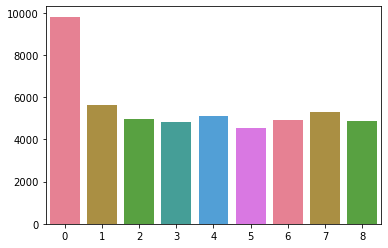

In [98]:
train_classes = [label for _, label in train_set]
data_count = Counter(train_classes)
print(mode,data_count)
palette = sns.color_palette("husl")
sns.barplot(x=list(data_count.keys()),y=list(data_count.values()),palette=palette)

tensor(0)


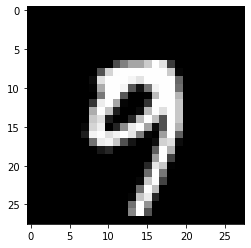

tensor(8)


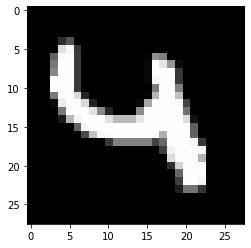

tensor(3)


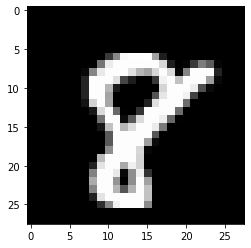

tensor(4)


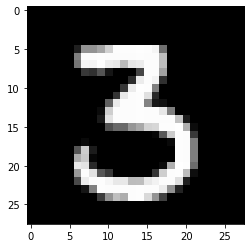

tensor(2)


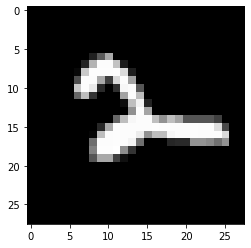

tensor(2)


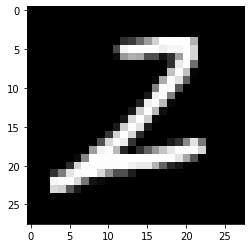

tensor(1)


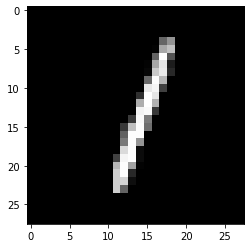

tensor(8)


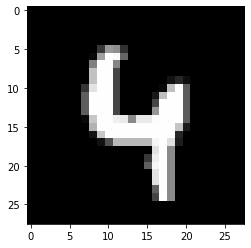

tensor(8)


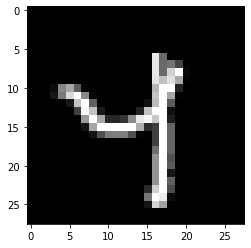

tensor(0)


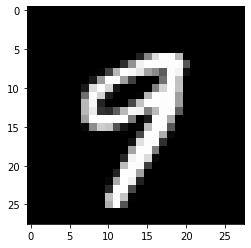

tensor(0)


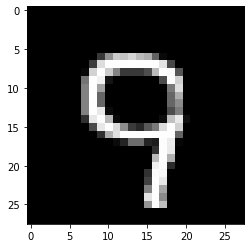

tensor(0)


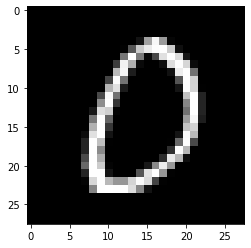

tensor(2)


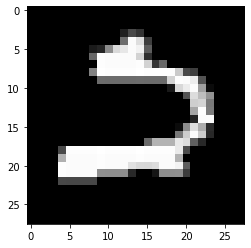

tensor(0)


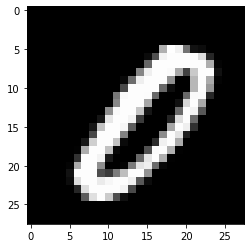

tensor(4)


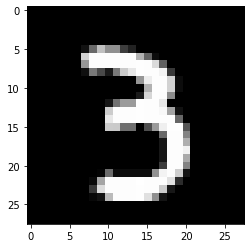

tensor(7)


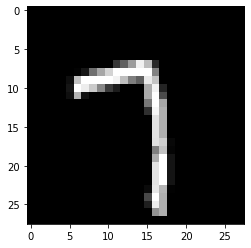

tensor(0)


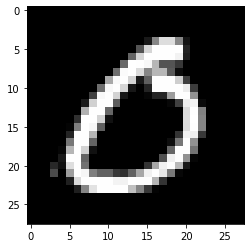

tensor(2)


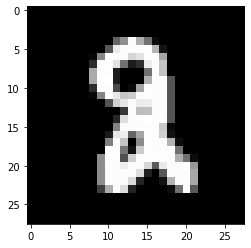

tensor(0)


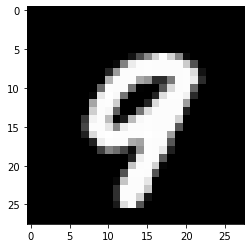

tensor(5)


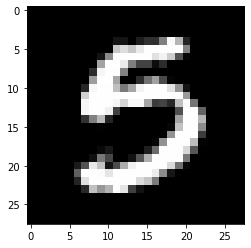

tensor(2)


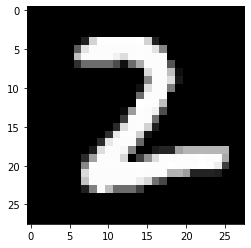

tensor(6)


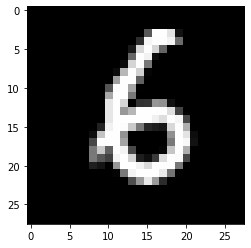

tensor(1)


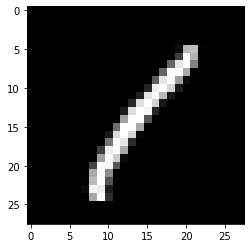

tensor(1)


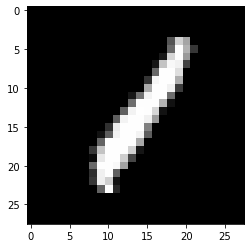

tensor(8)


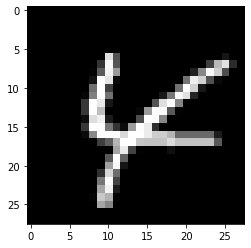

tensor(5)


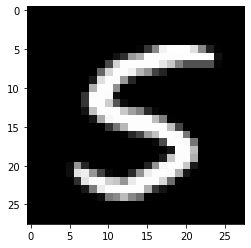

tensor(6)


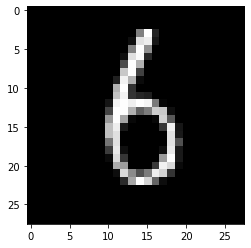

tensor(6)


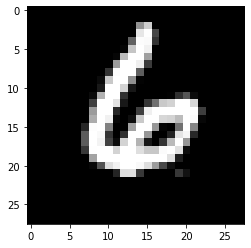

tensor(0)


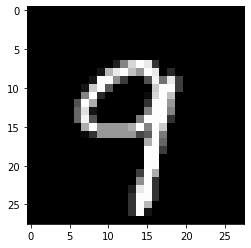

tensor(7)


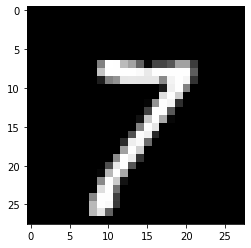

tensor(0)


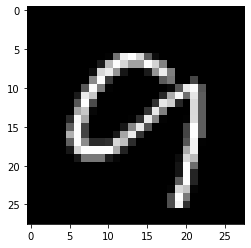

tensor(4)


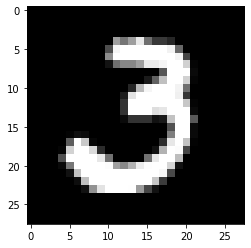

tensor(3)


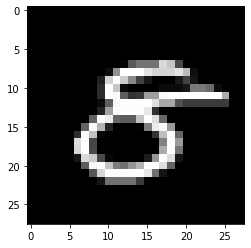

tensor(5)


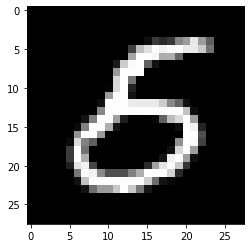

tensor(6)


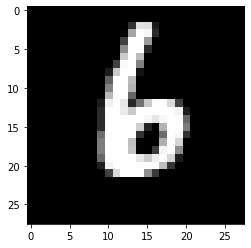

tensor(5)


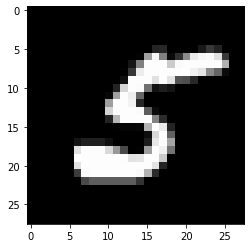

tensor(1)


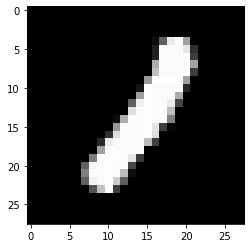

tensor(7)


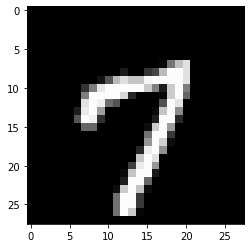

tensor(0)


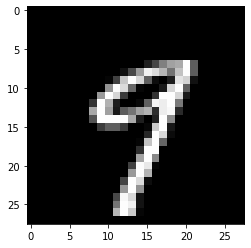

tensor(1)


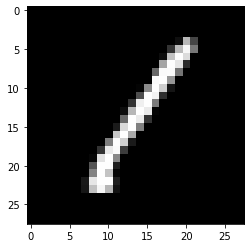

In [99]:
for index, (images,labels) in enumerate(train_loader):
    if index % 10 == 0:
        print(labels[1])
        plt.imshow(images[1].reshape(28,28), cmap="gray")
        plt.show()